# Day 13: Monte Carlo

---

- Reminder on probability stuff



In [1]:
import pandas as pd 
import grama as gr 
import numpy as np
from scipy.optimize import minimize
from plotnine import *
DF = gr.Intention()

## Dataset of steel alloy specimens
from grama.data import df_ruff


## Reminder

---


In [2]:
## Fit a marginal
marg_tys = gr.marg_named(df_ruff.TYS, "lognorm")

TYS lower ~ 154.698


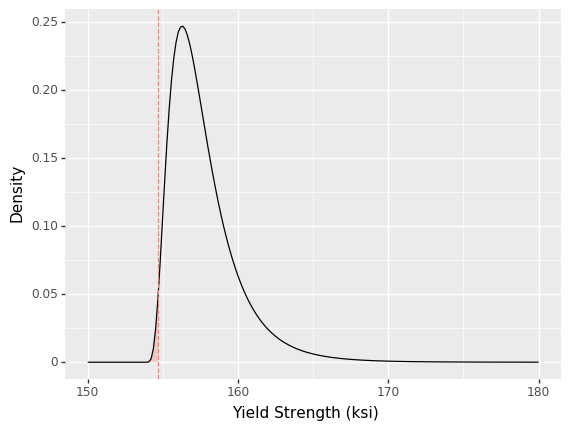

<ggplot: (8781793936033)>

In [3]:
## Compute lower quantile as design value
tys_lower = marg_tys.q(0.01)
print("TYS lower ~ {0:4.3f}".format(tys_lower))

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(DF.TYS <= tys_lower),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    + geom_vline(
        xintercept=tys_lower,
        linetype="dashed",
        color="salmon",
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)

## Random Variable Interactions

---

Let's let $Z$ be normally distributed; we write $Z \sim N(\mu, \sigma^2)$.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


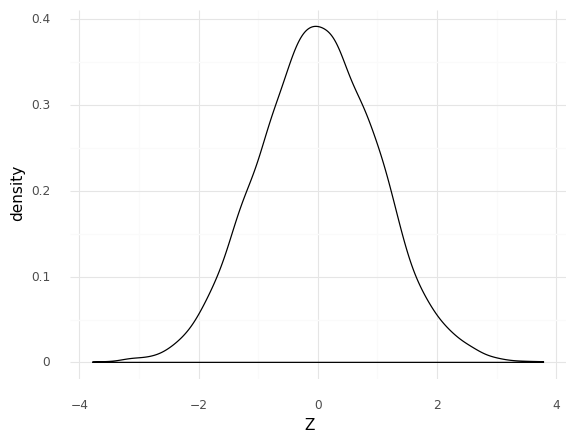

<ggplot: (8781767050201)>

In [18]:
(
    ## Build a simple model
    gr.Model()
    >> gr.cp_marginals(Z=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom", skip=True)
    ## Visualize
    >> ggplot(aes("Z"))
    + geom_density()
    + theme_minimal()
)

What will this look like if we consider

$$X = Z^2$$


eval_monte_carlo() is rounding n...


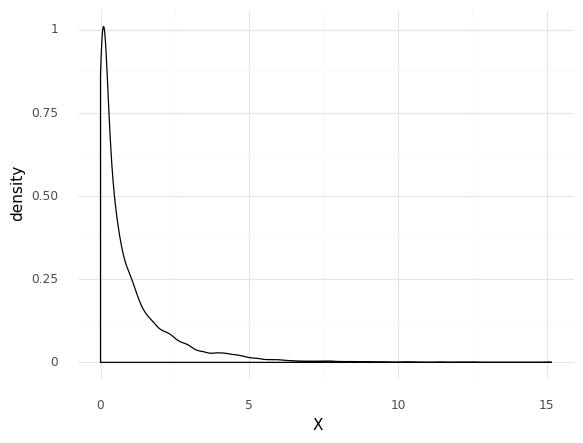

<ggplot: (8781766656969)>

In [20]:
(
    ## Build a simple model
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(X=df.Z**2),
        var=["Z"],
        out=["X"],
    )
    >> gr.cp_marginals(Z=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    ## Visualize
    >> ggplot(aes("X"))
    + geom_density()
    + theme_minimal()
)

It's not possible for $Z^2 < 0$! The two values in $Z^2 = Z \times Z$ must always have the same sign. So the result $Z^2$ can't *possibly* be a normal distribution (it can't take negative values).

*Aside*: Distributions of this form fall under the family of [chi-square distributions](https://en.wikipedia.org/wiki/Chi-square_distribution).

But what if we allow $Z_1, Z_2 \sim N(0, 1^2)$ to be *independent* normal random variables?


eval_monte_carlo() is rounding n...


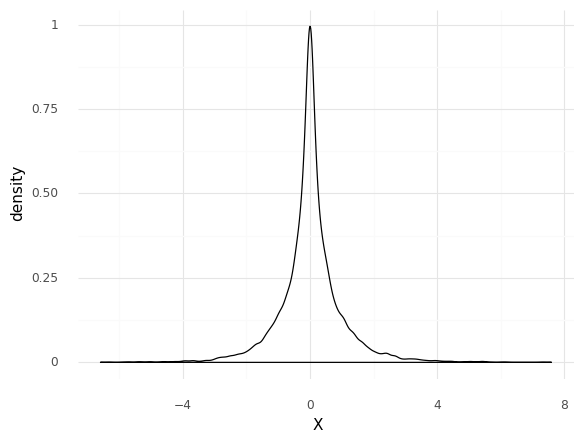

<ggplot: (8781749839101)>

In [21]:
(
    ## Build a simple model
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(X=df.Z1 * df.Z2),
        var=["Z1", "Z2"],
        out=["X"],
    )
    >> gr.cp_marginals(
        Z1=dict(dist="norm", loc=0, scale=1),
        Z2=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    ## Visualize
    >> ggplot(aes("X"))
    + geom_density()
    + theme_minimal()
)

This looks *a bit* like a normal distribution, but [it's not](https://math.stackexchange.com/questions/101062/is-the-product-of-two-gaussian-random-variables-also-a-gaussian) (it turns out to be a difference of chi-squares). We could do some sneaky math to write down a distribution for this quantity $Z_1 \times Z_2$, or we could just simulate its behavior using *Monte Carlo*.

Sometimes, modelers will pick random variables because it makes the math easy (coughnormaldistributionscough). We're going to learn Monte Carlo so we can choose random variables that best represent the underlying uncertainty, but still make quantiative statements through simulation.


## Uncertainty Propagation - Monte Carlo

---

Here's an analogy:

> - **Finite Element Analysis** (FEA) is to structural analysis, as
> - **SPICE**, and other circuit simulators, are to circuit analysis, as
> - **Monte Carlo** is to probabilistic analysis


Monte Carlo has its theoretical justification in the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers)


In [28]:
# TEMPLATE: Monte Carlo example
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    ## Monte Carlo
    # Draw samples
    >> gr.ev_monte_carlo(n=1e2, df_det="nom", skip=True)
    # Compute summary
    >> gr.tf_summarize(
        mu_hat=gr.mean(DF.X)
    )
)

eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


,mu_hat
0,-0.010471


Monte Carlo (usually) comes in two steps:

1. Draw **independent** realizations from our random variable(s); this is what `gr.ev_monte_carlo()` does.
2. Use the sa


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


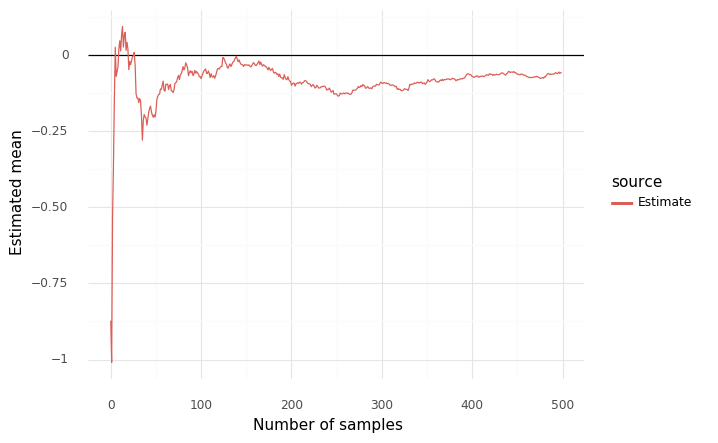

<ggplot: (8781749844717)>

In [45]:
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    ## Monte Carlo
    # Draw samples
    >> gr.ev_monte_carlo(n=5e2, df_det="nom", skip=True)
    # Compute summary
    >> gr.tf_mutate(
        # Compute the running mean, to visualize
        mu_hat=gr.cummean(DF.X),
        idx=DF.index,
    )
    
    ## Visualize
    >> gr.tf_mutate(source="Estimate")
    >> ggplot()
    + geom_hline(
        color="black",
        yintercept=0,
    )
    + geom_line(
        mapping=aes("idx", "mu_hat", color="source"),
    )
    + theme_minimal()
    + labs(
        x="Number of realizations",
        y="Estimated mean"
    )
)

## Useful tools

Using `gr.ev_monte_carlo()` with `skip=True` will allow you to quickly visualize the input distributions:

eval_monte_carlo() is rounding n...
Estimated runtime for design with model (Cantilever Beam):
  0.000503 sec
Calling plot_scattermat....


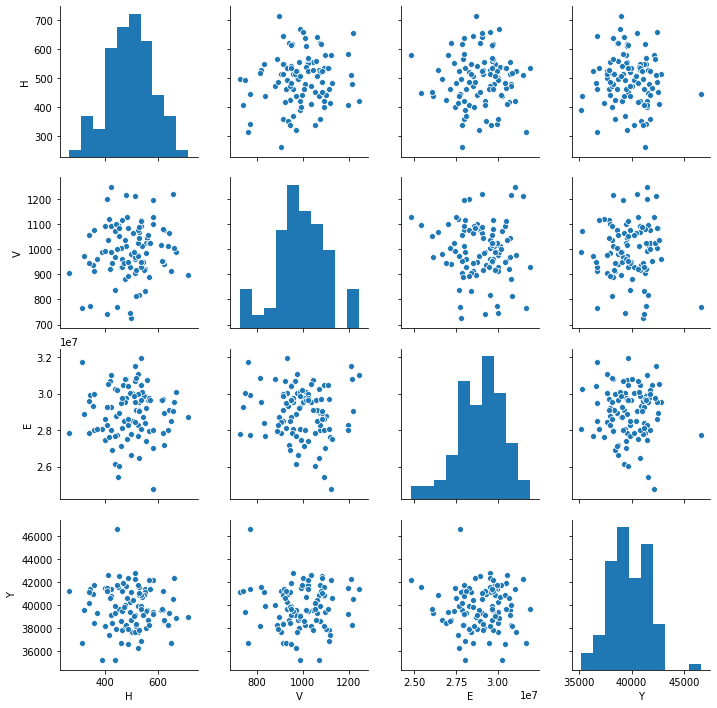

In [16]:
(
    md_beam
    >> gr.ev_monte_carlo(n=1e2, df_det="nom", skip=True)
    >> gr.pt_auto()
)